---
## Notebook admin

In [1]:
# Keep notebook cleaner once finalised
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set up MatPlotLib
%matplotlib inline
# Change default colour scheme:
plt.style.use('seaborn-colorblind')

---

## Initial setup - import data, define constants, and plot

### Import the probability data

In this example, we will use the data for an LVO treated with thrombectomy at times $t=0$ and $t=t_\mathrm{ne}$. Import the probability bins from file:

In [4]:
from outcome_utilities.mRS_datasets import (
    dict_t0_treatment_lvo_ect,  dict_no_treatment_lvo_ect )

In [5]:
mrs_prob_bins_t0_treatment = dict_t0_treatment_lvo_ect['bins']
mrs_prob_dist_t0_treatment = dict_t0_treatment_lvo_ect['dist']

mrs_prob_bins_no_treatment = dict_no_treatment_lvo_ect['bins']
mrs_prob_dist_no_treatment = dict_no_treatment_lvo_ect['dist']

Define the no-effect time for thrombectomy:

In [6]:
t_ne = 8 * 60 # minutes

### Define the constants $a$, $b$, and $A$

gives us cumulative prob bins

This uses the same calculations as in the mathematics notebook.

In [7]:
def find_mrs_constants(mrs_prob_bins_t0_treatment, mrs_prob_bins_no_treatment, t_ne):
    """
    
    """
    # Use the [:-1] slice to exclude mRS<=5.
    G_t0  = np.log(      mrs_prob_bins_t0_treatment[:-1])
    B_t0  = np.log(1.0 - mrs_prob_bins_t0_treatment[:-1])
    G_tne = np.log(      mrs_prob_bins_no_treatment[:-1])
    B_tne = np.log(1.0 - mrs_prob_bins_no_treatment[:-1])

    a = (G_t0 - B_t0) - (G_tne - B_tne)
    b = -a/t_ne
    A = a + (G_tne - B_tne)

    return a, b, A

In [8]:
a, b, A = find_mrs_constants(mrs_prob_bins_t0_treatment, 
                             mrs_prob_bins_no_treatment, t_ne)

Each of these arrays contains five values, one for each mRS<=0,1,2,3,4. 

In [9]:
a

array([2.92153649, 2.50547806, 2.08799477, 2.25100113, 2.35247623])

In [10]:
b

array([-0.00608653, -0.00521975, -0.00434999, -0.00468959, -0.00490099])

In [11]:
A

array([0.19892614, 0.84026081, 1.36510562, 2.36703744, 3.96339452])

### Define a function to plot the probability bins

calculste  cum prob <= lines from before, but colour in spaces in between. view as stacked bins.

Plot probability over a time range $t$:

In [12]:
t = np.arange(0,t_ne)

In [13]:
def plot_probs_filled(A,b,t):
    # P(mRS<=5)=1.0 at all times, so we cannot define A, a, and b.
    # Instead append to this array a 0.0, which won't be used directly
    # but will allow the "for" loop to go round one extra time.
    A = np.append(A,0.0)

    for i,A_i in enumerate(A):

        # Define the probability line, p_i:
        if i<5:
            p_i = 1.0/(1.0 + np.exp(-A_i -b[i]*t)) 
        else:
            # P(mRS<=5)=1.0 at all times:
            p_i = np.full(t.shape,1.0)
        # Plot it as before and store the colour used:
        l, = plt.plot(t, p_i, '-')#, label = f'mRS <= {i}')
        colour = l.get_color()


        # Fill the area between p_i and the line below, p_j.
        # This area marks where mRS <= the given value.
        # If p_j is not defined yet (i=0), set all p_j to zero:
        p_j = p_j if i>0 else np.zeros_like(p_i)
        plt.fill_between(t, p_i, p_j, label=f'mRS = {i}',
                         color=colour, alpha=0.3 )
        # ^ alpha is used as a quick way to lighten the fill colour.

        # Store the most recently-created line for the next loop:
        p_j = p_i


    plt.legend(loc='center left', bbox_to_anchor=[1.0,0.5,0.2,0.2])
    plt.ylabel('Probability')
    plt.xlabel('Onset to treatment time (mins)')
    plt.ylim(-0.02,1.02)

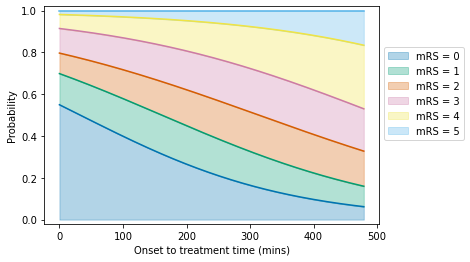

In [14]:
plot_probs_filled(A,b,t)
plt.show()

---

## Predicting mRS at a given time

Define an example x and treatment time:

In [15]:
x = 0.75
treatment_time = 210 # minutes

Plot which mRS bin this x value lands in at the treatment time:

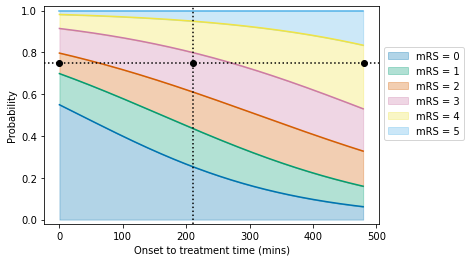

In [16]:
# Draw the filled bins as before:
plot_probs_filled(A,b,t)

# Draw vertical line:
plt.axvline(treatment_time, color='k', linestyle=':')
    
# Draw horizontal line:
plt.axhline(x, color='k', linestyle=':')
    
# Add scatter markers along the horizontal line at the three key times:
for v in [0,treatment_time,t_ne]:
    plt.scatter(v,x,color='k',marker='o')
    
plt.show()

For this example patient, the mRS changes from 2 at the start time to 4 at the no-effect time. By looking at where the horizontal and vertical lines meet, we can see that being treated at this example treatment time would result in an mRS of 3 - an increase of one point on the scale compared with no treatment.

To automatically find which mRS bin patient x will fall into at the selected treatment time, we need to know the bins at this time:

In [17]:
def find_mrs_bins_t(A,b,treatment_time):
    """
    
    """
    mrs_prob_bins_t_treatment = []
    for i,A_i in enumerate(A):
        p_i = 1.0/(1.0 + np.exp(-A_i -b[i]*treatment_time)) 
        mrs_prob_bins_t_treatment.append(p_i)

    return mrs_prob_bins_t_treatment

In [18]:
mrs_prob_bins_t_treatment = find_mrs_bins_t(A,b,treatment_time)

mrs_prob_bins_t_treatment

[0.25364871619956864,
 0.43637532692526065,
 0.6110214606451044,
 0.7993480184486166,
 0.9495107387476389]

And then we use the digitise function:

In [55]:
mRS_t0 = np.digitize(x, mrs_prob_bins_t0_treatment, right=True)
mRS_t  = np.digitize(x, mrs_prob_bins_t_treatment,  right=True)
mRS_no = np.digitize(x, mrs_prob_bins_no_treatment, right=True)


print(f'mRS pre-stroke:             {mRS_t0}')
print(f'mRS if not treated:         {mRS_no}')
print(f'mRS if treated at time={treatment_time}: {mRS_t}')

mRS pre-stroke:             2
mRS if not treated:         4
mRS if treated at time=210: 3


---

## Multiple patients

The same process can be performed for a larger sample of $x$ values at a fixed treatment time to calculate the percentage of patients who should see an improvement in mRS compared with receiving no treatment. 

First we'll consider only 4 patients at the same treatment time as before and check each improvement individually.

In [20]:
xs = np.arange(0.2,1.0,0.2)

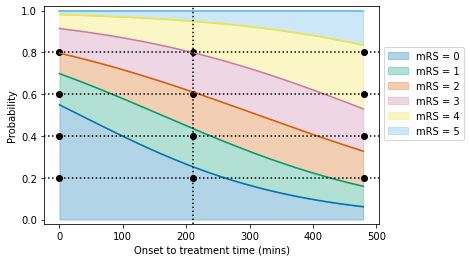

In [21]:
# Draw the filled bins as before:
plot_probs_filled(A,b,t)

# Draw vertical line:
plt.axvline(treatment_time, color='k', linestyle=':')
    
for x in xs:
    # Draw horizontal line:
    plt.axhline(x, color='k', linestyle=':')
    
    # Add scatter markers along the horizontal line at the three key times:
    for v in [0,treatment_time,t_ne]:
        plt.scatter(v,x,color='k',marker='o')
    
plt.show()

In [22]:
mRS_vals_t0_treatment = []
mRS_vals_t_treatment  = []
mRS_vals_no_treatment = []

for x in xs: 
    # Find which bin 'x' lies in,
    # i.e. which plotted probability line it lies under,
    # at time t=0, t=treatment_time, and t=T_0.
    mRS_t0_treatment = np.digitize(x, mrs_prob_bins_t0_treatment, right=True)
    mRS_t_treatment  = np.digitize(x, mrs_prob_bins_t_treatment,  right=True)
    mRS_no_treatment = np.digitize(x, mrs_prob_bins_no_treatment, right=True)
    
    # Store these in the lists:
    mRS_vals_t0_treatment.append(mRS_t0_treatment)
    mRS_vals_t_treatment.append( mRS_t_treatment)
    mRS_vals_no_treatment.append(mRS_no_treatment)

In [23]:
print(mRS_vals_t0_treatment)
print(mRS_vals_t_treatment)
print(mRS_vals_no_treatment)

[0, 0, 1, 3]
[0, 1, 2, 4]
[2, 3, 4, 4]


For each of the patients, record whether their mRS improved compared with their untreated mRS level. If improved, record a 1, otherwise record a 0.

In [24]:
mRS_improved = []
for i, mRS_t_treatment in enumerate(mRS_vals_t_treatment):
    mRS_change = mRS_vals_no_treatment[i] - mRS_t_treatment
    if mRS_change >= 1:
        mRS_improved.append(1)
    else:
        mRS_improved.append(0)
        
mRS_improved

[1, 1, 1, 0]

Then take the average of the 1s and 0s across all patients. 

In [25]:
treatment_effect = np.mean(mRS_improved)

print(f'Probability of mRS improving by 1 or more: {treatment_effect}')

Probability of mRS improving by 1 or more: 0.75


This matches the changes in mRS that we can read off the plot.

---

## Generalisation

To find a better estimate of the effectiveness of this treatment, we need to do the same calculation with a much higher number of patients. We'll sample random values of x for 100 patients and rewrite the code from before into one cell:

write into functions

Inputs: 

- Time to thrombectomy or thrombolysis
- Time to zero effect (set at 8 hours, but optionally changed)

Outpts:

- Single sample of mRS if untreated, and mRS if treated
- 100 samples of mRS if untreated, and mRS if treated, and probability of mRS being improved by at least 1

In [56]:
def stroke_outcome(mrs_prob_bins_t0_treatment, mrs_prob_bins_no_treatment, 
                   treatment_time, no_effect_time=8*60, 
                   xs=[], number_of_patients=100, print_result=1):
    """
    Inputs
    
    dist_0:           1D list or numpy array. Element i corresponds to 
                      the proportion of patients that had mRS=i, before stroke or 
                      if treated at time t=0.
    dist_F:           1D list or numpy array. Element i corresponds to 
                      the proportion of patients that had mRS=i if not treated
                      or treated after time_zero_effect
    treatment_time:   int. time in minutes between stroke and treatment    
    time_zero_effect: int. time in minutes after stroke that treatment
                      has no effect.                      
    single:           bool. If True, model will only perform one iteration    
    n_iter:           int. If single=False, number of iterations the model 
                      will perform.
    xs:               1D list or numpy array. List of values of 'x' to try.
                      
    
    Outputs
    
    mRS_0:  1D list. mRS if treated at time t=0     
    mRS_F:  1D list. mRS if treated at time_zero_effect  
    mRS_T:  1D list. mRS if treated at treatment_time
    """
    ### Step 1: Find a, b, and A
    a, b, A = find_mrs_constants(mrs_prob_bins_t0_treatment, 
                                 mrs_prob_bins_no_treatment, no_effect_time)

    ### Step 2: Find probability bins at treatment_time
    mrs_prob_bins_t_treatment = find_mrs_bins_t(A,b,treatment_time)

    ### Step 3: Find the mRS of patient x at the key times

    # Values of x to try:
    if len(xs)>0:
        number_of_patients = len(xs)
    else:
        # Generate random patients:
        xs = np.random.rand(number_of_patients)

    # Find mRS for each patient x:
    mRS_vals_t0_treatment = []
    mRS_vals_t_treatment  = []
    mRS_vals_no_treatment = [] 

    count=0
    while count<number_of_patients:
        # Generate a random number between 0 and 1:
        x = xs[count]

        # Find which bin 'x' lies in at the three key times:
        mRS_vals_t0_treatment.append(
            np.digitize(x, mrs_prob_bins_t0_treatment, right=True))
        mRS_vals_t_treatment.append( 
            np.digitize(x, mrs_prob_bins_t_treatment,  right=True))
        mRS_vals_no_treatment.append(
            np.digitize(x, mrs_prob_bins_no_treatment, right=True))

        count += 1


    ### Step 4: Find the probability of improvement

    # For all of the patients (n_iter values of 'x'), record whether their 
    # mRS improved (mRS_T, with treatment at treatment_time) compared with
    # their untreated mRS level (in mRS_F). 
    # Then take the average of the 1s and 0s across all n_iter patients. 
    treatment_effect = np.mean(
        [1 if mRS_vals_no_treatment[i] - T >=1 else 0 
         for i,T in enumerate(mRS_vals_t_treatment)] )


    ### Print some useful things:
    if print_result>0:
        if len(xs)==1:
            print(f'mRS pre-stroke:            ',
                  f'{mRS_vals_t0_treatment[-1]}')
            print(f'mRS if not treated:        ',
                  f'{mRS_vals_no_treatment[-1]}')
            print(f'mRS if treated at time={treatment_time}:',
                  f'{mRS_vals_t_treatment[-1]}')
        else:
            print(f'Probability of mRS improving by 1 or more: ',
                  f'{treatment_effect}')

    return (mRS_vals_t0_treatment, mRS_vals_no_treatment, 
            mRS_vals_t_treatment, treatment_effect)

### Test the function

Use this function here in a few test cases:

#### Test 1

Using the same patient x at the same time before should print the same values of mRS as we found earlier.

In [57]:
# treatment_time = np.random.randint(0, 8*60)
# print(treatment_time)

# Manually set treatment time:
treatment_time = 210

In [58]:
# # Randomly generate x:
# x = np.random.rand()
# print(x)

# Manually set x:
x=0.75

In [59]:
(mRS_vals_t0_treatment, mRS_vals_no_treatment, 
 mRS_vals_t_treatment, treatment_effect) = (
    stroke_outcome(mrs_prob_bins_t0_treatment, mrs_prob_bins_no_treatment, 
                   treatment_time, no_effect_time=t_ne, xs=[x]))

mRS pre-stroke:             2
mRS if not treated:         4
mRS if treated at time=210: 3


#### Test 2 

We can also test 100 patients with randomly-generated x:

In [60]:
(mRS_vals_t0_treatment, mRS_vals_no_treatment, 
 mRS_vals_t_treatment, treatment_effect) = (
    stroke_outcome(mrs_prob_bins_t0_treatment, mrs_prob_bins_no_treatment, 
                   treatment_time, no_effect_time=t_ne, 
                   number_of_patients=100))

Probability of mRS improving by 1 or more:  0.76


---

### Predicting mRS for groups of patients

And by running the function multiple times, we can compare a range of different times for different groups of 100 patients:

In [61]:
treatment_times = np.random.randint(0, t_ne, size=100)

print(np.mean(treatment_times), np.std(treatment_times))

251.52 133.20664247701762


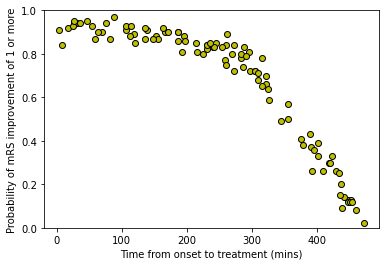

In [62]:
for t in treatment_times:
    (mRS_vals_t0_treatment, mRS_vals_no_treatment, 
     mRS_vals_t_treatment, treatment_effect) = (
    stroke_outcome(mrs_prob_bins_t0_treatment, mrs_prob_bins_no_treatment, 
                   t, no_effect_time=t_ne, 
                   number_of_patients=100, print_result=0))
    plt.scatter(t, treatment_effect, color='y', edgecolor='k')
    
plt.xlabel('Time from onset to treatment (mins)')
plt.ylabel('Probability of mRS improvement of 1 or more')
plt.ylim(0,1)
plt.show()

Two points at almost the same treatment time can have probabilities around 0.2 apart depending on the groups of patients considered. 

---

### For a given start mRS, find the probability of each mRS at a time _t_

Use this function to find the probability of each mRS at a given time:

In [79]:
def prob_mRS_in_xrange(bins,xmin,xmax,m_start='?',time='???'):
    """
    Given some range in cumulative probability, find the probability of being
    in each mRS bin at a given time t. 
    
    Inputs:
    bins    - List or np.array. List of cumulative probabilities of each mRS 
              at a given time t. 
    xmin    - Float. Minimum P(mRS<=x|t) to check.
    xmax    - Float. Maximum P(mRS<=x|t) to check
    m_start - String. Used for printing only, the mRS at t=0.
    time    - String. Used for printing only, the value of t.
    
    Returns:
    -
    """
    # Find intersections of the probability lines with the vertical t line
    # within the specified range of x:
    m_int = np.where( (bins<xmax) & (bins>xmin) )[0]
    if len(m_int)>0:
        # Find the probability of each m:
        p_int = bins[m_int]
        
        # Include the boundary values at xmin, xmax:
        m_ints = [m_int[0]-1, *m_int, m_int[-1]+1]
        p_ints = [xmin, *p_int, xmax]
        
        # Store probabilities here:
        pm_list = []
        for i in range(len(m_ints)-1):
            # Find the proportion of the probability range (y-axis span)
            # that is covered by this value of mRS.
            pmin = p_ints[i]
            pmax = p_ints[i+1]
            p_m = (pmax-pmin)/(xmax-xmin)
            print(f'P(mRS={m_ints[i]:1} | m_start={m_start:1}',
                  f't={time:3}): {p_m:1.4f}')
            pm_list.append(p_m)
        print('Sanity check: sum of probs', np.sum(pm_list))
    else:
        # If there are no intersections in the chosen x range,
        # find the fixed value of mRS in this range.
        try:
            m_int = np.where(bins>=xmax)[0][0]-1
        except:
            # m>4 isn't included in the input data.
            m_int = 5
        
        print(f'P(mRS={m_int:1} | m_start={m_start:1}',
              f't={time:3}): 1.0')

In [80]:
# Setup parameters:
treatment_time = np.random.randint(0, 8*60) # 100
print('Treatment time (mins): ', treatment_time)

   
# Generate probabilities xs that give a t=0 mRS of m_start.
m_start = 1 
xmin = mrs_prob_bins_t0_treatment[m_start-1]
xmax = mrs_prob_bins_t0_treatment[m_start]

Treatment time (mins):  231


Plot the considered mRS as a probability range on the y-axis:

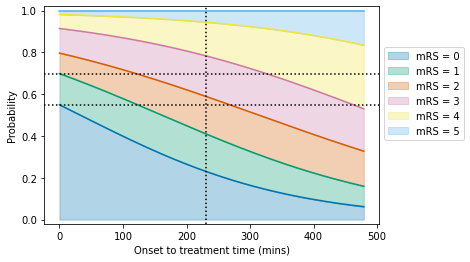

m_start: 1

Time = 0
P(mRS=0 | m_start=1 t=  0): 1.0

Time = 231
P(mRS=1 | m_start=1 t=231): 0.2654
P(mRS=2 | m_start=1 t=231): 0.7346
Sanity check: sum of probs 1.0

Time = 480
P(mRS=5 | m_start=1 t=480): 1.0


In [83]:
# Calculate the mRS bins at treatment_time:
mrs_prob_bins_t_treatment = [np.exp(A_i + b[i]*treatment_time)/(1+np.exp(A_i + b[i]*treatment_time))\
             for i,A_i in enumerate(A[:-1])]
mrs_prob_bins_t_treatment = np.concatenate((mrs_prob_bins_t_treatment,[1]))

# Draw covered range:
t = np.arange(0,8*60)
# Similar plot to before:
plot_probs_filled(A,b,t)


# New bits:
# Vertical line at t=0, treatment time, and t=T_0:
plt.axvline(treatment_time, color='k', linestyle=':')
# Horizontal lines where considered 'x' are:
for x in [xmin,xmax]:
    plt.axhline(x, color='k', linestyle=':')
    
plt.show()


# Use this function to find the probability of each mRS at a given time:
print('m_start:', m_start)
# Check probability of each mRS at t=0, t=T, and t=T_0:
print('\nTime =', 0)
prob_mRS_in_xrange(mrs_prob_bins_t0_treatment,xmin,xmax, m_start, 0)

print('\nTime =', treatment_time)
prob_mRS_in_xrange(mrs_prob_bins_t_treatment,xmin,xmax, m_start, treatment_time)

print('\nTime =', 8*60)
prob_mRS_in_xrange(mrs_prob_dist_no_treatment,xmin,xmax, m_start, 8*60)

---